Generate final manuscript figures.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker

from fme_diags.time_mean import (
    compute_time_mean_bias, plot_time_mean_bias,
    plot_time_mean_bias_list
)
from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.tropics.tropics import (
    compute_wavenumber_frequency_spectra, 
    plot_wavenumber_frequency_spectra
)
from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics, 
    open_autoregressive_inference, open_reference,
)

_ = xr.set_options(keep_attrs=True)

## Get config, define constants, make output plots directory, and open datasets

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
    REF_KEY = "42-years-training-set-reference"
else:
    RUN_KEY = os.environ["RUN_KEY"]
    REF_KEY = os.environ["REFERENCE_KEY"]
    
FV3GFS_KEY = "retrain-30e-rs1-10yr-ema"
    
print(f"Run key: {RUN_KEY}")
print(f"Reference key: {REF_KEY}")
print(f"FV3GFS key: {FV3GFS_KEY}")

Run key: 42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema
Reference key: 42-years-training-set-reference
FV3GFS key: retrain-30e-rs1-10yr-ema


In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)

WK_LAT_BOUNDS = (-15, 15)

WK_SEG_SIZE = 128
    
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"
    
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 -89.24 ... 8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    OCNFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    top_of_atmos_upward_shortwave_flux             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path_due_to_advection  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_1                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_0                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FLDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ICEFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
ref_ds = open_reference(
    path = config["runs"][REF_KEY]["url"],
    start = run_kwargs["start"],
    lat_coords=ds["lat"],
    step_freq=run_kwargs["step_freq"],
    calendar=run_kwargs["calendar"],
)
ref_ds

<xarray.Dataset>
Dimensions:                                        (time: 14600, lat: 180,
                                                    lon: 360)
Coordinates:
  * lat                                            (lat) float32 -89.24 ... 8...
  * lon                                            (lon) float64 0.5 ... 359.5
  * time                                           (time) object 0054-01-01 0...
Data variables: (12/69)
    FLDS                                           (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    FLUT                                           (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    FSDS                                           (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    ICEFRAC                                        (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    LANDFRAC                                       (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    LHFLX                                          (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    ...                                             ...
    surface_upward_longwave_flux                   (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    surface_upward_shortwave_flux                  (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path                   (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path_due_to_advection  (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    top_of_atmos_upward_shortwave_flux             (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
    total_water_path                               (time, lat, lon) float32 dask.array<chunksize=(124, 180, 360), meta=np.ndarray>
Attributes: (12/31)
    Conventions:               CF-1.7
    NCO:                       netCDF Operators version 5.1.6 (Homepage = htt...
    case:                      20230614.v2.LR.F2010
    cell_measures:             area: area
    cell_methods:              time: mean
    contact:                   e3sm-data-support@llnl.gov
    ...                        ...
    time_period_freq:          month_1
    title:                     EAM History file information
    topography_file:           /lcrc/group/e3sm/data/inputdata/atm/cam/topo/U...
    units:                     m2/s2
    username:                  ac.golaz
    vertical_coordinate:       The pressure at level interfaces can by comput...

In [7]:
assert np.all(ds["lat"] == ref_ds["lat"])

In [8]:
variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

In [9]:
def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
}

FV3GFS_CONVERSIONS = {all_vars_fv3gfs[k]: UNIT_CONVERSIONS[k] for k in UNIT_CONVERSIONS.keys()}

## Figure 1

In [11]:
da_precip = UNIT_CONVERSIONS[PRECIP](ds[PRECIP])

with ProgressBar():
    da_precip = da_precip.resample(time="1D").mean("time").compute()

hist_range = da_precip.min().compute().item(), da_precip.max().compute().item()

[########################################] | 100% Completed | 26.3s


In [32]:
%%time

precip_hist_ds = compute_histograms(
    da_precip, n_bins=300, hist_range=hist_range, lat_weighted=False
)

CPU times: user 49.6 s, sys: 563 ms, total: 50.1 s
Wall time: 51.7 s


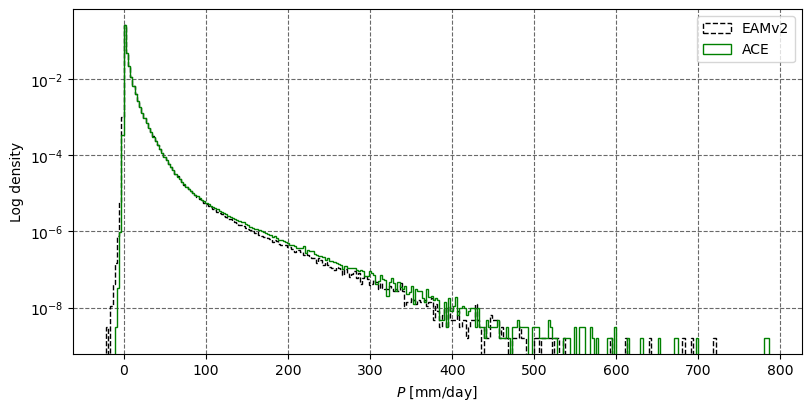

In [35]:
fig, ax = plot_time_mean_histogram(
    precip_hist_ds, figsize=(8, 4), log=True, density=True, histtype="step",
    labels={"prediction": "ACE", "target": "EAMv2"}
)
# ax.set_title("Precipitation")
ax.set_xlabel(f"{all_vars[PRECIP]} [{da_precip.units}]")
ax.set_ylabel("Log density")
ax.grid(linestyle="--", color="dimgray")
plt.legend()
fig.show()

In [36]:
fig.savefig(os.path.join(OUTDIR, "precip_density.pdf"), bbox_inches="tight")

## Figure 2

In [37]:
%%time

da_wk = da_precip.isel(sample=0)
spectra = compute_wavenumber_frequency_spectra(
    da_wk, 
    segment_size=WK_SEG_SIZE, 
    latitude_bounds=WK_LAT_BOUNDS
)
spectra

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 -14.46 -13.46 -12.47 -11.47 ... 12.47 13.46 14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 -14.46 -13.46 -12.47 -11.47 ... 12.47 13.46 14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})


Frequency smoothing 10 times for all wavenumbers (pos frqs only)


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 -14.46 -13.46 -12.47 -11.47 ... 12.47 13.46 14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 -14.46 -13.46 -12.47 -11.47 ... 12.47 13.46 14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

<xarray.Dataset>
Dimensions:     (wavenumber: 361, frequency: 129, component: 4, source: 2)
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' ... 'background'
    init        object 0054-01-01 00:00:00
  * source      (source) <U10 'target' 'prediction'
Data variables:
    spectrum    (source, component, wavenumber, frequency) float64 1.969e-16 ...

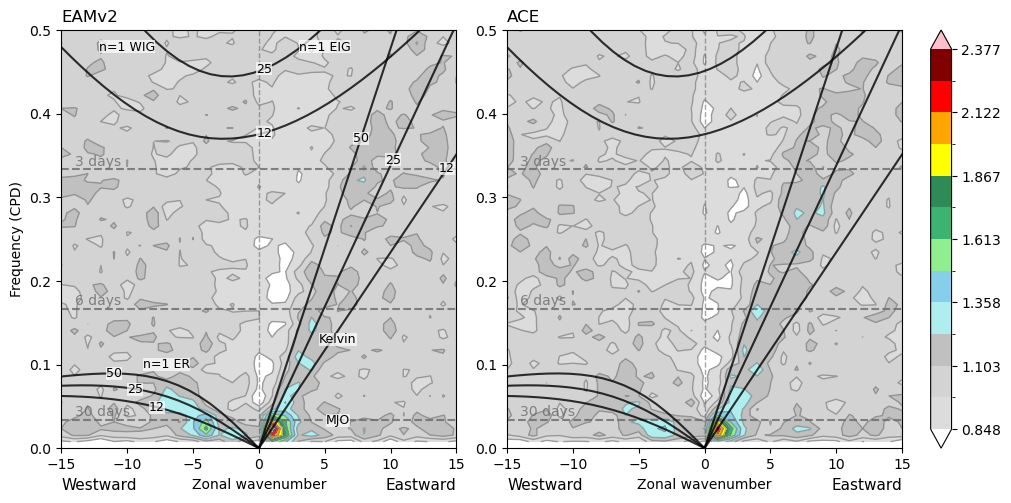

In [44]:
fig, axs = plot_wavenumber_frequency_spectra(
    spectra, 
    component="symmetric",
    figsize=(10, 5),
    plot_error=False,
    labels={"prediction": "ACE", "target": "EAMv2"},
)
fig.suptitle("")
fig.show()

In [45]:
fig.savefig(os.path.join(OUTDIR, "wk.pdf"), bbox_inches="tight")

## Figure 3

In [12]:
time_mean_bias = compute_time_mean_bias(
    da_precip.sel(source="prediction"),
    da_precip.sel(source="target")
)

In [13]:
ref_da_precip = UNIT_CONVERSIONS[PRECIP](ref_ds[PRECIP])

with ProgressBar():
    ref_da_precip = ref_da_precip.resample(time="1D").mean("time").compute()

ref_time_mean_bias = compute_time_mean_bias(
    ref_da_precip,
    da_precip.sel(source="target"),
)

[########################################] | 100% Completed | 20.3s


time_mean_bias min: -2.46478057
time_mean_bias max: 3.69937658
baseline_time_mean_bias min: -1.44117332
baseline_time_mean_bias max: 1.57442224


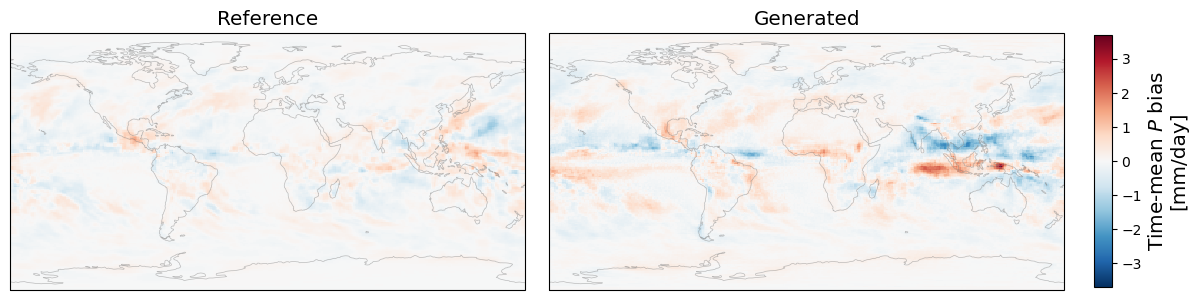

In [14]:
fig, axs = plot_time_mean_bias(
    time_mean_bias, 
    ref_time_mean_bias,
    var_name=all_vars[PRECIP],
    figsize=(12, 3),
    verbose=True,
)
fig.show()

In [15]:
fig.savefig(os.path.join(OUTDIR, "precip_bias.pdf"), bbox_inches="tight")

## Figure 4

In [16]:
da_OLR = ds[OLR].assign_attrs(units=FLUX_UNITS)

time_mean_bias_OLR = compute_time_mean_bias(
    da_OLR.sel(source="prediction"),
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 44.5s


In [17]:
ref_da_OLR = ref_ds[OLR].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OLR = compute_time_mean_bias(
    ref_da_OLR,
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 39.3s


In [18]:
da_OSR = ds[OSR].assign_attrs(units=FLUX_UNITS)
time_mean_bias_OSR = compute_time_mean_bias(
    da_OSR.sel(source="prediction"),
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed | 48.8s


In [19]:
ref_da_OSR = ref_ds[OSR].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OSR = compute_time_mean_bias(
    ref_da_OSR,
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed |  1min 14.1s


time_mean[i], $RSW$ bias, (min, max): -22.50528145, 21.39746094
time_mean[i], $RSW$ bias, area-weighted mean: -0.94787186
time_mean[i], $RSW$ bias, area-weighted RMSE: 4.17011856
baseline_time_mean[i], $RSW$ bias (min, max): -9.61332512, 9.01838970
baseline_time_mean[i], $RSW$ bias, area-weighted mean: 0.06675146
baseline_time_mean[i], $RSW$ bias, area-weighted RMSE: 1.62589753
time_mean[i], $OLR$ bias, (min, max): -14.83921051, 12.24756050
time_mean[i], $OLR$ bias, area-weighted mean: -0.59279084
time_mean[i], $OLR$ bias, area-weighted RMSE: 2.82810224
baseline_time_mean[i], $OLR$ bias (min, max): -6.22723198, 6.10110044
baseline_time_mean[i], $OLR$ bias, area-weighted mean: 0.00837357
baseline_time_mean[i], $OLR$ bias, area-weighted RMSE: 1.24603879


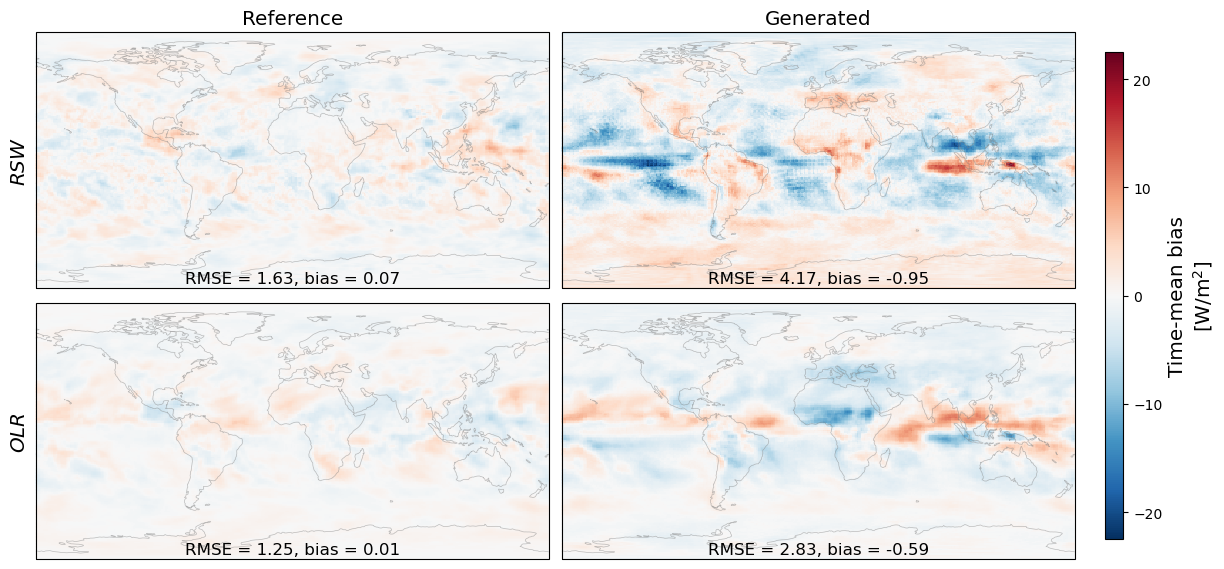

In [20]:
fig, axs = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=[all_vars[OSR], all_vars[OLR]],
    figsize=(12, 5.8),
    verbose=True,
)
fig.show()

In [21]:
fig.savefig(os.path.join(OUTDIR, "osr_olr_bias.pdf"), bbox_inches="tight")

## Figure 3 (alternative combined version of Fig 3 + 4)

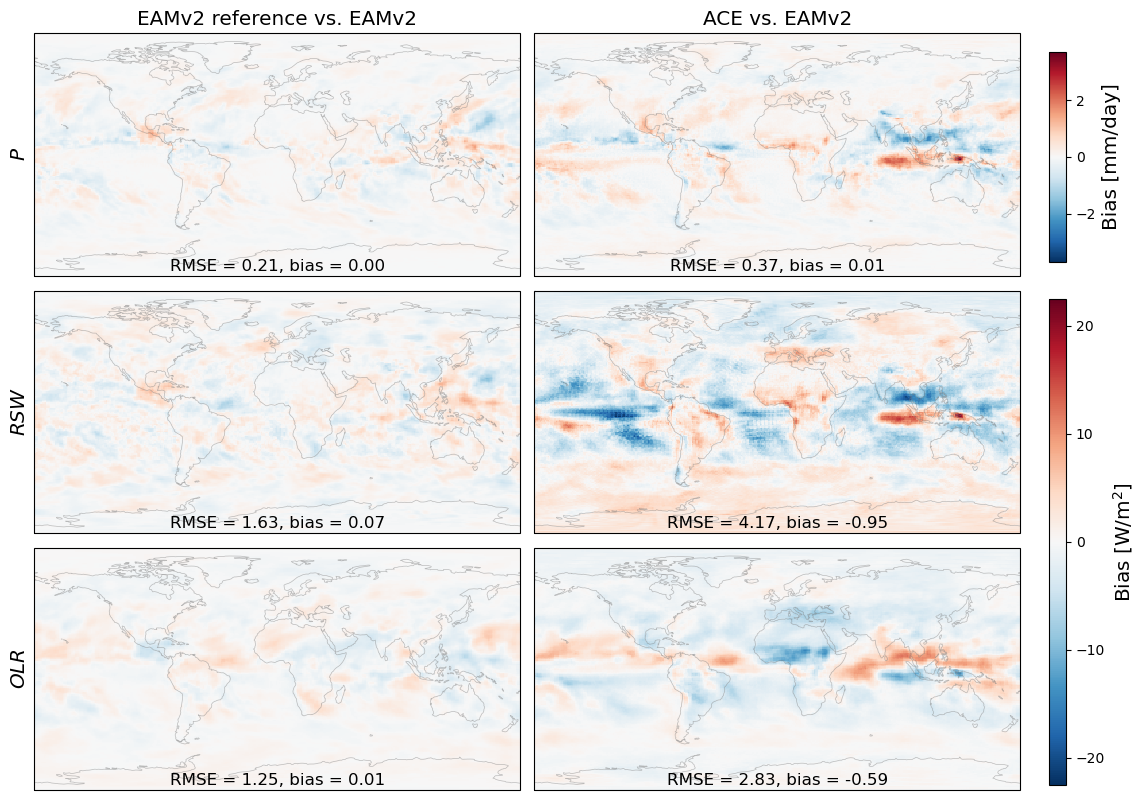

In [22]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(11.5, 8.1),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

im_precip = plot_time_mean_bias_list(
    [time_mean_bias],
    [ref_time_mean_bias],
    var_names=[all_vars[PRECIP]],
    axs=axs[0:1]
)

im_fluxes = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=[all_vars[OSR], all_vars[OLR]],
    axs=axs[1:]
)

axs[0][0].set_title("EAMv2 reference vs. EAMv2", fontsize="x-large")
axs[0][1].set_title("ACE vs. EAMv2", fontsize="x-large")

axs[1][0].set_title("")
axs[1][1].set_title("")

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.91, 0.67, 0.015, 0.26])
cbar = fig.colorbar(
    im_precip,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"Bias [{time_mean_bias.units}]", fontsize="x-large"
)

cbar_ax = fig.add_axes([0.91, 0.025, 0.015, 0.6])
cbar = fig.colorbar(
    im_fluxes,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"Bias [{time_mean_bias_OSR.units}]", fontsize="x-large"
)

fig.show()

In [23]:
fig.savefig(os.path.join(OUTDIR, "bias_maps.pdf"), bbox_inches="tight")

## Supplemental Figure 1

In [24]:
all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

In [25]:
api = wandb.Api()

In [26]:
inf_run = api.run(get_wandb_path(config, RUN_KEY))
ref_inf_run = api.run(get_wandb_path(config, REF_KEY))
fv3gfs_inf_run = api.run(get_wandb_path(config, FV3GFS_KEY))

Bias

In [27]:
inf_bias = load_global_time_mean_metrics(
    wandb_run=inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=all_vars, 
    run_label="ACE-EAMv2",
    apply_funcs=UNIT_CONVERSIONS,
)

ref_inf_bias = load_global_time_mean_metrics(
    wandb_run=ref_inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=all_vars,
    run_label="Reference",
    apply_funcs=UNIT_CONVERSIONS,
)

fv3gfs_inf_bias = load_global_time_mean_metrics(
    wandb_run=fv3gfs_inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=fv3gfs_vars_dict,
    run_label="ACE-FV3GFS",
    apply_funcs=FV3GFS_CONVERSIONS,
)
fv3gfs_inf_bias.index = inf_bias.index

inf_bias_df = inf_bias.join([
    fv3gfs_inf_bias.drop("label", axis=1),
    ref_inf_bias.drop("label", axis=1)
])
inf_bias_df[["ACE-EAMv2", "ACE-FV3GFS", "Reference"]]

,ACE-EAMv2,ACE-FV3GFS,Reference
PS,2.301562e-03,4.547226e-01,4.541708e-04
U_0,7.885051e-01,-6.862642e-01,-2.078110e-02
U_1,6.190356e-01,-2.859339e-01,6.928731e-02
U_2,3.171358e-01,-1.555692e-01,3.038932e-02
U_3,1.062806e-01,-2.602013e-01,1.913289e-02
U_4,-1.473532e-02,-2.078817e-01,8.963352e-03
U_5,-9.261003e-02,-2.513521e-01,4.561521e-03
U_6,-3.297923e-02,-2.047241e-01,-7.418378e-03
U_7,-2.524025e-03,-1.701530e-01,-7.000032e-03
V_0,-1.676950e-04,1.471950e-02,2.880184e-04


RMSE

In [28]:
inf_rmse = load_global_time_mean_metrics(
    wandb_run=inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=all_vars, 
    run_label="ACE-EAMv2",
    apply_funcs=UNIT_CONVERSIONS,
)

ref_inf_rmse = load_global_time_mean_metrics(
    wandb_run=ref_inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=all_vars,
    run_label="Reference",
    apply_funcs=UNIT_CONVERSIONS,
)

fv3gfs_inf_rmse = load_global_time_mean_metrics(
    wandb_run=fv3gfs_inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=fv3gfs_vars_dict,
    run_label="ACE-FV3GFS",
    apply_funcs=FV3GFS_CONVERSIONS,
)
fv3gfs_inf_rmse.index = inf_rmse.index

inf_rmse_df = inf_rmse.join([
    fv3gfs_inf_rmse.drop("label", axis=1), 
    ref_inf_rmse.drop("label", axis=1), 
    all_units
])
inf_rmse_df[["ACE-EAMv2", "ACE-FV3GFS", "Reference"]]

,ACE-EAMv2,ACE-FV3GFS,Reference
PS,6.062101e-01,1.034889e+00,4.057131e-01
U_0,1.253934e+00,2.182911e+00,4.770657e-01
U_1,1.300621e+00,9.245745e-01,4.218268e-01
U_2,1.416398e+00,1.509914e+00,5.794182e-01
U_3,1.047343e+00,1.147957e+00,5.360406e-01
U_4,7.338293e-01,8.164312e-01,4.251361e-01
U_5,6.602782e-01,6.658629e-01,3.491294e-01
U_6,5.627533e-01,5.434758e-01,3.029726e-01
U_7,4.697918e-01,4.563607e-01,2.699280e-01
V_0,3.114873e-01,3.276795e-01,2.293321e-01


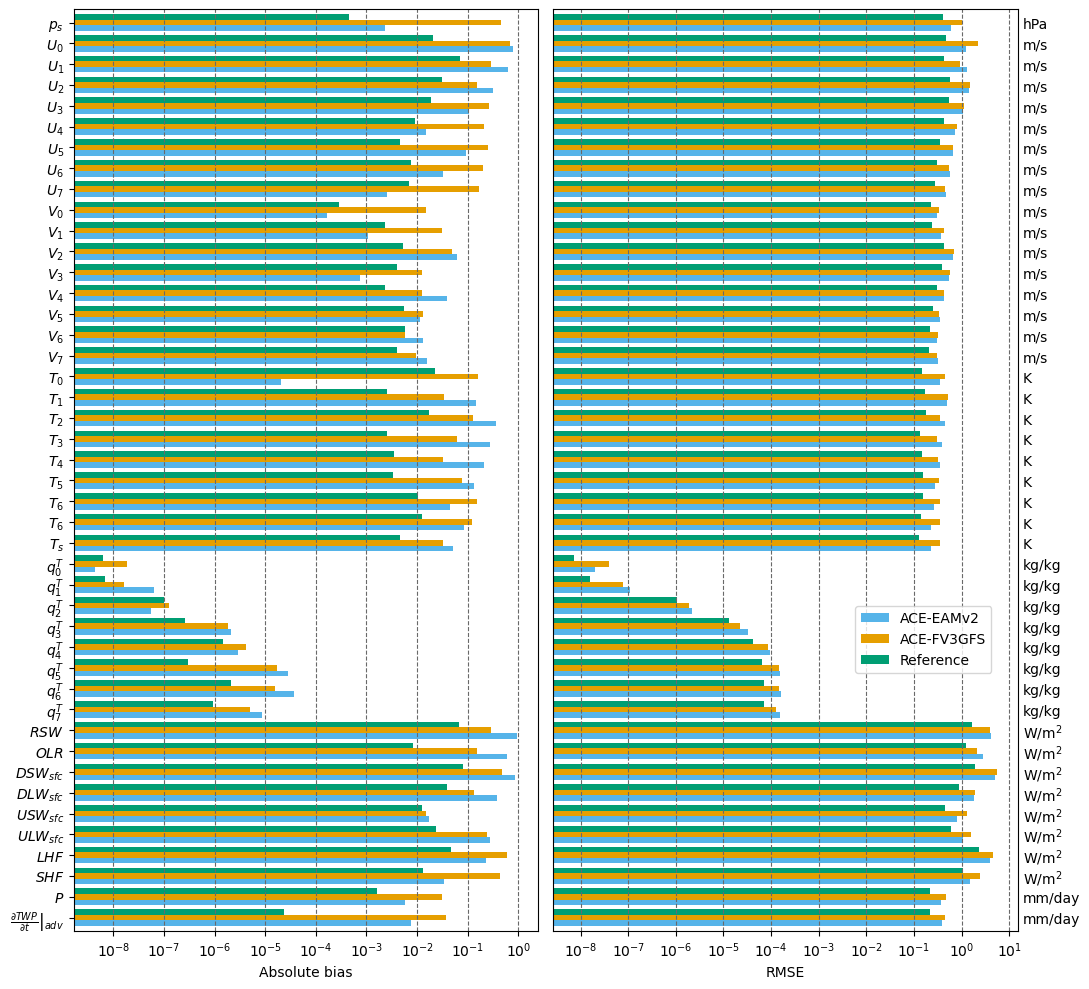

In [29]:
order = list(all_vars.keys())[::-1]

abs_bias_ordered = np.abs(inf_bias_df.loc[order].set_index("label"))
rmse_ordered = inf_rmse_df.loc[order]

fig, axs = plt.subplots(1, 2, figsize=(11, 10))
abs_bias_ordered.plot.barh(ax=axs[0], logx=True, legend=False, width=0.8)
rmse_ordered.plot.barh(ax=axs[1], logx=True, legend=False, width=0.8)

axs[0].set_xticks(np.logspace(-8, 0, 9))
axs[0].set_xlabel('Absolute bias')
axs[0].set_ylabel('')

axs[1].set_xticks(np.logspace(-8, 1, 10))
axs[1].set_xlabel('RMSE')
axs[1].yaxis.set_tick_params(labelleft=False, labelright=True, length=0.0)
axs[1].set_yticklabels(rmse_ordered["units"])

for ax in axs:
    ax.grid(axis="x", linestyle="--", color="dimgray")
    
axs[1].legend(loc=(0.65, 0.28))
    
plt.tight_layout()

In [30]:
fig.savefig(os.path.join(OUTDIR, "global_time_means.pdf"), bbox_inches="tight")

## Supplemental Figure 2

In [46]:
orig_fontsize = matplotlib.rcParams["font.size"]

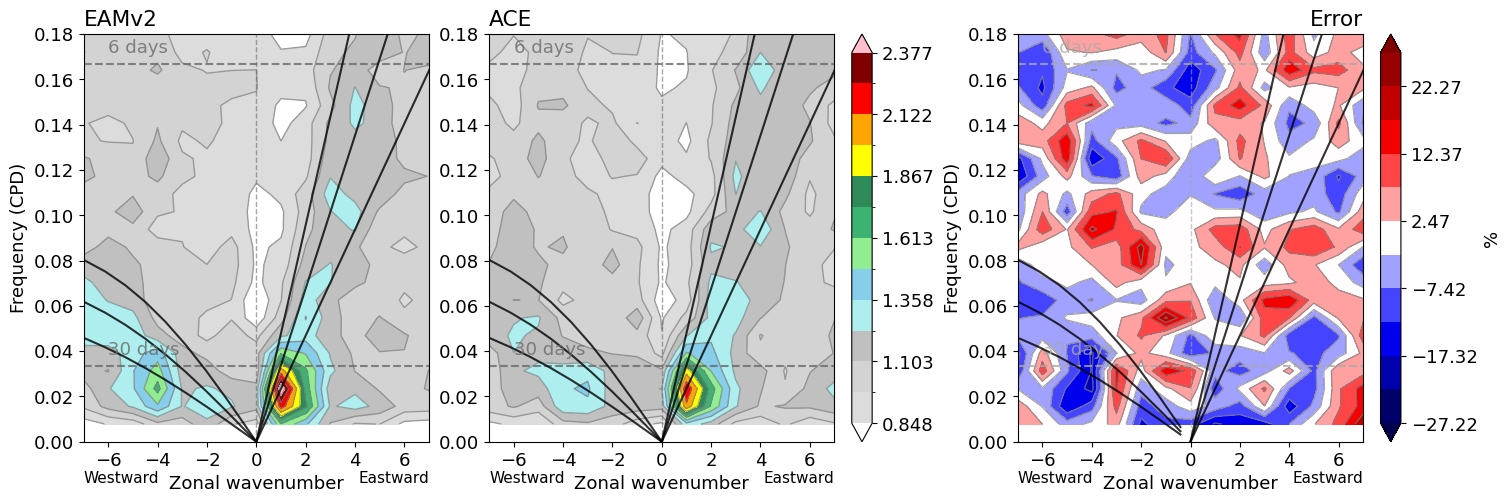

In [47]:
matplotlib.rcParams["font.size"] = 13

fig, axs = plot_wavenumber_frequency_spectra(
    spectra, 
    component="symmetric",
    figsize=(15, 5),
    plot_error=True,
    mjo_zoom=True,
    labels={"prediction": "ACE", "target": "EAMv2"},
)
fig.suptitle("")
fig.show()

matplotlib.rcParams["font.size"] = orig_fontsize

In [48]:
fig.savefig(os.path.join(OUTDIR, "wk_zoom.pdf"), bbox_inches="tight")